In [1]:
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from ATLAS_data.effFunctions import eventEff,vertexEff
from atlas_susy_2018_13_Recast import (getLLPs, getJets, getDisplacedJets, eventAcc, 
                                       vertexAcc, getModelDict)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution

delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['YlGnBu']

Welcome to JupyROOT 6.28/06


### ATLAS data

In [2]:
data_obs = np.genfromtxt('./ATLAS_data/HEPData-ins2628398-v1-csv/yields_trackless_SR_observed.csv',
                         delimiter=',',skip_header=10)
data_exp = np.genfromtxt('./ATLAS_data/HEPData-ins2628398-v1-csv/yields_trackless_SR_expected_ewk.csv',
                         delimiter=',',skip_header=11)

### Recast Data

In [3]:
inputFile = '../pp2BB1j_atlas_scan/Events/run_01/cdfo_415_400.0_tau_3e-01_delphes_events.root'
sr = 'Trackless'
modelDict = getModelDict([inputFile],model='sbottom')

mLLP =  415.0
width (GeV) =  1.935882e-15
tau (ns) =  0.34000006198724925


#### Track Eff = 100%

In [4]:
eff = 1.0
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
totalweightPB = 0.0
lumi = 139.0
mDV_nTracks_weights = []
for ievt in range(nevts):    
   
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Event.At(0).Weight/nevts     
    totalweightPB += weightPB
    ns = weightPB*1e3*lumi # number of signal events

    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,trackEff=eff)
    jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
    jetsDisp = getDisplacedJets(jets,llps)
    
    # Event acceptance:
    jet_acc = eventAcc(jets,jetsDisp,sr=sr)
    if (not jet_acc): continue
    ns = ns*jet_acc
    
    # Event efficiency
    ev_eff = eventEff(jets,llps,sr=sr,extrapolate=True)
    ns = ns*ev_eff
    # Vertex acceptances:
    v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,d0min=2.0) for llp in llps])
    # Vertex efficiencies:
    v_eff = np.array([vertexEff(llp,extrapolate=True) for llp in llps])
        

    for illp,llp in enumerate(llps):
        wv = v_acc[illp]*v_eff[illp]
        if wv <= 0.:
            continue
        mDV_nTracks_weights.append([llp.mDV,llp.nTracks,ns*wv])

f.Close()

In [5]:
mDV_nTracks_weights = np.array(mDV_nTracks_weights)

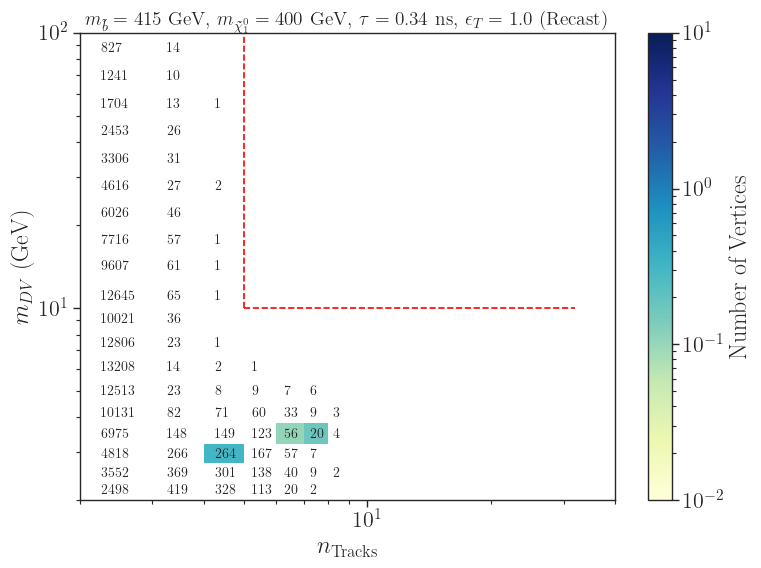

In [12]:
fig = plt.figure(figsize=(8,6))
mDV_bins = sorted(np.unique(data_exp[:,4]))
mDV_bins = np.append(mDV_bins,data_exp[-1,5])
n_bins = sorted(np.unique(data_exp[:,1]))
# n_bins = np.append(n_bins,data_exp[-1,2])
# mDV_bins = np.append(mDV_bins,np.arange(200.,1000.,100.))
h = plt.hist2d(mDV_nTracks_weights[:,1],mDV_nTracks_weights[:,0],cmap=cm,
               weights=mDV_nTracks_weights[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-2,vmax=10))


for pt in data_obs:
    plt.text((pt[0]+pt[1])/2.,(pt[3]+pt[4])/2.,'%i' %pt[-1],fontsize=10)

plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(2,mDV_bins.max())
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.title(r'$m_{Y} = %1.0f$ GeV, $m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns, $\epsilon_{T} = %1.1f$ (Recast)' 
          %(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'],eff),fontsize=14)
plt.tight_layout()
plt.show()


#### Track Eff = 50%

In [13]:
effB = 0.5

f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
ntotal = 0
totalweightPB = 0.0
lumi = 139.0
mDV_nTracks_weightsB = []
for ievt in range(nevts):    
   
    ntotal += 1
    tree.GetEntry(ievt)   
    weightPB = tree.Event.At(0).Weight/nevts     
    totalweightPB += weightPB
    ns = weightPB*1e3*lumi # number of signal events

    llps = getLLPs(tree.bsm,tree.bsmDirectDaughters,tree.bsmFinalDaughters,trackEff=effB)
    jets = getJets(tree.GenJet,pTmin=25.,etaMax=5.0)
    jetsDisp = getDisplacedJets(jets,llps)
    
    # Event acceptance:
    jet_acc = eventAcc(jets,jetsDisp,sr=sr)
    if (not jet_acc): continue
    ns = ns*jet_acc
    
    # Event efficiency
    ev_eff = eventEff(jets,llps,sr=sr,extrapolate=True)
    ns = ns*ev_eff
    # Vertex acceptances:
    v_acc = np.array([vertexAcc(llp,Rmax=300.0,zmax=300.0,Rmin=4.0,d0min=2.0) for llp in llps])
    # Vertex efficiencies:
    v_eff = np.array([vertexEff(llp,extrapolate=True) for llp in llps])
        

    for illp,llp in enumerate(llps):
        wv = v_acc[illp]*v_eff[illp]
        if wv <= 0.:
            continue
        mDV_nTracks_weightsB.append([llp.mDV,llp.nTracks,ns*wv])

f.Close()

In [8]:
mDV_nTracks_weightsB = np.array(mDV_nTracks_weightsB)

In [14]:
fig = plt.figure(figsize=(8,6))
mDV_bins = sorted(np.unique(data_exp[:,4]))
mDV_bins = np.append(mDV_bins,data_exp[-1,5])
# n_bins = sorted(np.unique(data_exp[:,1]))
# n_bins = np.append(n_bins,data_exp[-1,2])
mDV_bins = np.append(mDV_bins,np.arange(200.,1000.,100.))
h = plt.hist2d(mDV_nTracks_weightsB[:,1],mDV_nTracks_weightsB[:,0],cmap=cm,
               weights=mDV_nTracks_weightsB[:,2],bins=(n_bins,mDV_bins),norm=LogNorm(vmin=1e-2,vmax=10))


for pt in data_obs:
    plt.text((pt[0]+pt[1])/2.,(pt[3]+pt[4])/2.,'%i' %pt[-1],fontsize=10)

plt.hlines(y=10.0,xmin=5.,xmax=max(n_bins),colors='red',linestyle='dashed')
plt.vlines(x=5.0,ymin=10.,ymax=max(mDV_bins),colors='red',linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$m_{DV}$ (GeV)')
plt.xlabel(r'$n_{\rm Tracks}$')
plt.ylim(2,mDV_bins.max())
plt.xlim(2,40)
fig.colorbar(h[3], ax=plt.gca(),label='Number of Vertices')
plt.title(r'$m_{Y} = %1.0f$ GeV, $m_{\tilde \chi_1^0} = %1.0f$ GeV, $\tau = %1.2f$ ns, $\epsilon_{T} = %1.1f$ (Recast)' 
          %(modelDict['mLLP'],modelDict['mLSP'],modelDict['tau_ns'],eff),fontsize=14)


plt.tight_layout()
plt.show()


TypeError: list indices must be integers or slices, not tuple

<Figure size 800x600 with 0 Axes>